Total images collected: 6000
Training images: 4200
Validation images: 600
Testing images: 1200
Found 4200 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.


C:\Users\surya\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


C:\Users\surya\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 347ms/step - accuracy: 0.6019 - loss: 33.5255 - val_accuracy: 0.9000 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 338ms/step - accuracy: 0.9614 - loss: 0.4372 - val_accuracy: 0.9650 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 332ms/step - accuracy: 0.9252 - loss: 1.1474 - val_accuracy: 0.9633 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 331ms/step - accuracy: 0.9541 - loss: 0.7950 - val_accuracy: 0.8450 - val_loss: 2.3487 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 331ms/step - accuracy: 0.9621 - loss: 0.6466 - val_accuracy: 0.9783 - val_loss: 0.2371 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 333ms/step - accuracy: 0.9803 - loss: 0.2275 - val_accuracy: 0.9717 - val_loss: 0.3013 - learning_rate: 0.0010
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 49s 357ms/step - accuracy: 0.9781 - loss

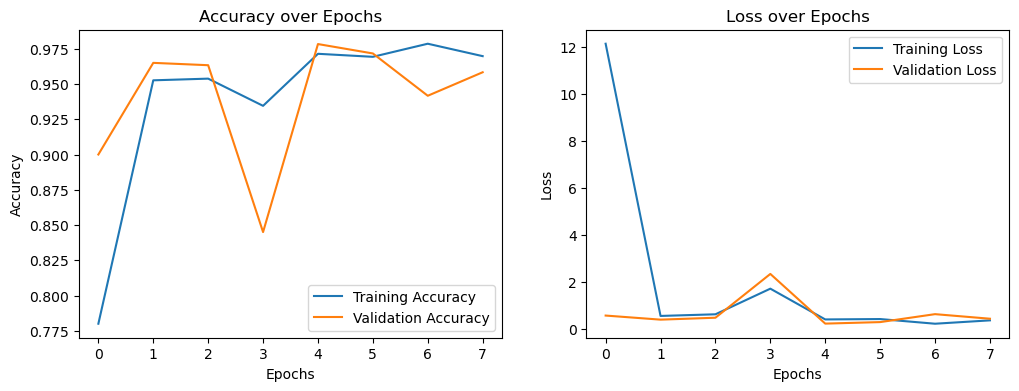

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Path to your dataset on the local computer
data_dir = r'<Mention ur dataset path>'  # Change to your local folder path

# Get class labels (subdirectories within your dataset folder)
class_labels = os.listdir(data_dir)

# Initialize lists to hold image paths and their corresponding labels
image_paths = []
labels = []

# Iterate through each class directory and collect image paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for img in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img)
        image_paths.append(img_path)
        labels.append(label)

# Convert labels to a numpy array
labels = np.array(labels)

# Check the total number of images collected
total_images = len(image_paths)
print(f"Total images collected: {total_images}")

# Split the dataset into 70% train, 10% validation, and 20% test
train_paths, remaining_paths, train_labels, remaining_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Further split the remaining data into 10% validation and 20% test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=2/3, stratify=remaining_labels, random_state=42
)

# Check the counts of images in each set
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Testing images: {len(test_paths)}")

# ImageDataGenerator for each set (train, validation, test)
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Flow from directories using the generated paths and labels
train_generator = train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    seed=True
)

val_generator = val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    seed=True
)

test_generator = test_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    seed=True
)

# Define the NN model
nn_model = Sequential([
    Flatten(input_shape=(256, 256, 3)),  # Flatten the input (no convolutional layers)
    Dense(128, activation='relu'),       # First dense layer
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer (number of classes)
])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
nn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = nn_model.fit(
    train_generator,
    epochs=10,  # Adjust epochs based on your needs
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plotting training and validation accuracy and loss over epochs
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plot function
plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

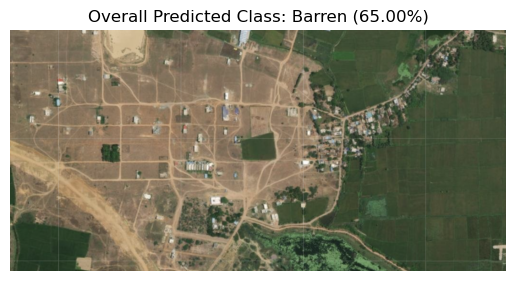

Area coverage percentages by class (based on patches):
Barren: 65.00%
Vegetation: 35.00%


In [11]:
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from PIL import Image

# Manually defined class labels
class_labels = {
    0: 'Barren',
    1: 'Vegetation',
    2: 'Water',
    # Add more class labels as needed
}

# Function to preprocess an individual patch for prediction
def preprocess_patch(patch):
    patch = patch.resize((256, 256))
    patch_array = image.img_to_array(patch)
    patch_array = patch_array / 255.0
    patch_array = np.expand_dims(patch_array, axis=0)
    return patch_array

# Function to classify each patch and calculate area coverage
def calculate_patch_coverage(img, patch_size=64):
    width, height = img.size
    patches_x = width // patch_size
    patches_y = height // patch_size
    patch_predictions = []

    for i in range(patches_x):
        for j in range(patches_y):
            left, upper = i * patch_size, j * patch_size
            right, lower = left + patch_size, upper + patch_size
            patch = img.crop((left, upper, right, lower))
            patch_array = preprocess_patch(patch)
            predictions = cnn_model.predict(patch_array)
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            patch_predictions.append(predicted_class_index)

    total_patches = len(patch_predictions)
    area_coverage = {class_labels[idx]: (patch_predictions.count(idx) / total_patches) * 100 
                     for idx in set(patch_predictions)}

    return area_coverage

# Function to predict coverage and determine the overall class based on patch coverage
def predict_image_and_coverage(img_path, patch_size=64):
    img = Image.open(img_path).convert("RGB")
    area_percentages = calculate_patch_coverage(img, patch_size=patch_size)

    # Determine overall predicted class based on the highest coverage percentage
    overall_predicted_class = max(area_percentages, key=area_percentages.get)
    overall_percentage = area_percentages[overall_predicted_class]

    plt.imshow(img)
    plt.title(f"Overall Predicted Class: {overall_predicted_class} ({overall_percentage:.2f}%)")
    plt.axis('off')
    plt.show()

    print("Area coverage percentages by class (based on patches):")
    for class_name, percentage in area_percentages.items():
        print(f"{class_name}: {percentage:.2f}%")

    return overall_predicted_class, area_percentages

# Example usage
img_path = r'<Replace with image path>'  # Replace with actual path to your test image
overall_class, area_coverage = predict_image_and_coverage(img_path, patch_size=64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

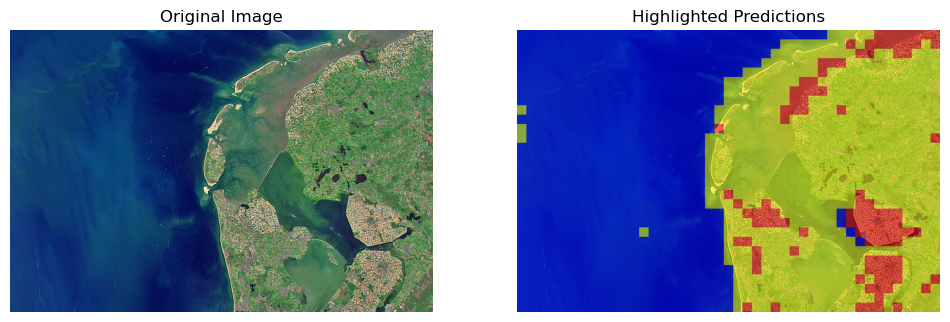

In [21]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the previously saved model if model is saved, else wise u can run directly in one stretch. Code snippet to save model file is at last.
nn_model = load_model(r'<>path of load model') #file type is h5

# Manually defined class labels
class_labels = {
    0: 'Barren',
    1: 'Vegetation',
    2: 'Water',
}

# Function to preprocess an individual patch for prediction
def preprocess_patch(patch):
    patch = patch.resize((256, 256))  # Resize to match the model input size
    patch_array = image.img_to_array(patch)
    patch_array = patch_array / 255.0  # Normalize to [0, 1]
    patch_array = np.expand_dims(patch_array, axis=0)  # Add batch dimension
    return patch_array

# Function to highlight regions in the image based on predictions
def highlight_regions(img_path, patch_size=64):
    img = Image.open(img_path).convert("RGB")
    width, height = img.size
    
    # Prepare the mask (initialize with black)
    mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Loop through the image in patches
    for i in range(0, width, patch_size):
        for j in range(0, height, patch_size):
            left, upper = i, j
            right, lower = left + patch_size, upper + patch_size
            
            # Ensure we don't go out of bounds
            if right > width or lower > height:
                continue
            
            patch = img.crop((left, upper, right, lower))
            patch_array = preprocess_patch(patch)
            
            # Make predictions for the patch
            predictions = nn_model.predict(patch_array)
            predicted_class_index = np.argmax(predictions, axis=1)[0]

            # Define colors for each class
            colors = {
                0: (255, 0, 0),    # Barren: Red
                1: (255, 255, 0),  # Vegetation: Yellow
                2: (0, 0, 255)     # Water: Blue
            }

            # Fill the mask with the corresponding color
            mask[upper:lower, left:right] = colors[predicted_class_index]

    # Create an image from the mask
    mask_image = Image.fromarray(mask)

    # Overlay the mask on the original image
    highlighted_image = Image.blend(img.convert("RGBA"), mask_image.convert("RGBA"), alpha=0.5)

    # Display the original image and highlighted image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title("Highlighted Predictions")
    plt.axis('off')

    plt.show()

# Example usage
img_path = r'C:\Users\surya\OneDrive\Desktop\Minor Project\Water and Vegetation.jpg'  # Replace with your test image path
highlight_regions(img_path, patch_size=16)


In [ ]:
from keras.models import load_model

# Assuming 'model' is your trained model, to save the model progress and utilise the model directly from the file without the repetition of training and etc.
cnn_model.save(r'C:\Users\surya\OneDrive\Desktop\Minor Project\Models\PerfectModel.h5')  # Replace with your desired path